In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2 as cv
import torch
import torch.nn as nn
from tqdm import tqdm
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics

In [3]:
import ultralytics
from ultralytics import YOLO
from ultralytics.nn.modules import C2f
from ultralytics.nn.modules.conv import Conv


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Training on {device}')

model = YOLO('yolov8n.pt').to(device)

Training on cuda


In [5]:
model.model.model

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C2f(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
        

In [6]:
backbone = model.model.model
new_layers = nn.Sequential(
    *list(backbone[:21]),
    C2f(256, 256, 1),
    C2f(256, 256, 1),
    *list(backbone[22:])
).to('cuda:0')

model.model.model = new_layers


In [7]:
model.info(True)

layer                                     name  gradient   parameters                shape         mu      sigma
    0                      model.0.conv.weight     False          432        [16, 3, 3, 3]   -0.00279      0.152 torch.float32
    1                        model.0.bn.weight     False           16                 [16]       2.97       1.86 torch.float32
    2                          model.0.bn.bias     False           16                 [16]      0.249       4.17 torch.float32
    3                      model.1.conv.weight     False         4608       [32, 16, 3, 3]   -0.00012      0.063 torch.float32
    4                        model.1.bn.weight     False           32                 [32]       5.02       1.12 torch.float32
    5                          model.1.bn.bias     False           32                 [32]      0.942        1.5 torch.float32
    6                  model.2.cv1.conv.weight     False         1024       [32, 32, 1, 1]     -0.011     0.0906 torch.float3

(241, 3584720, 920576, 0.0)

In [8]:
results = model.train(data='/content/drive/MyDrive/YOLO_detection/weapon_data/data.yaml',
        epochs= 120,
        imgsz=640,
        batch=32,
        augment=True,
        visualize=True,
        single_cls = True)

engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/YOLO_detection/weapon_data/data.yaml, epochs=120, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, kera

train: Scanning /content/drive/MyDrive/YOLO_detection/weapon_data/labels/train.cache... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/YOLO_detection/weapon_data/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      4.22G      4.696      7.577      4.268         25        640: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      4.21G      4.289      7.185      4.297         32        640: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120       4.2G      4.492      7.447      4.253         25        640: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120       4.2G      4.587      7.841      4.135         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120       4.2G      4.277      6.465      4.057         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120       4.2G      3.839      5.962      4.081         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120       4.2G      3.664      5.436      3.894         37        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       4.2G      3.402      5.384      3.895         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       4.2G      3.481      5.377      3.689         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120       4.2G      3.277      4.455      3.605         34        640: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120       4.2G      3.051      4.286      3.387         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120       4.2G      3.343      4.364      3.276         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       4.2G      2.896      3.633      3.186         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10         10    0.00052        0.1   0.000286   2.86e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120       4.2G      2.799      3.668      2.943         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]

                   all         10         10    0.00102        0.2   0.000616   0.000398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       4.2G      2.915      3.662      2.833         29        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         10         10   0.000997        0.2   0.000599   0.000267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120       4.2G       2.92      3.642      2.769         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         10         10   0.000997        0.2   0.000599   0.000267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120       4.2G      2.708      3.268      2.779         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         10         10   0.000978        0.2   0.000587   0.000294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      4.21G      2.605      3.151      2.607         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         10         10    0.00098        0.2   0.000589   0.000397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120       4.2G      2.629      2.906      2.491         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         10         10    0.00191        0.4    0.00135   0.000672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      4.24G      2.478      2.832      2.483         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         10    0.00225        0.5    0.00173   0.000853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120       4.2G      2.249      2.708      2.509         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         10         10    0.00274        0.6    0.00225   0.000864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      4.21G      2.415      2.835      2.346         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         10         10    0.00286        0.6     0.0023   0.000941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120       4.2G      2.548      2.659      2.418         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         10         10    0.00237        0.5    0.00179   0.000872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      4.21G      2.353       2.67      2.547         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         10         10    0.00245        0.5    0.00225   0.000923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120       4.2G      2.226      2.554      2.186         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         10         10    0.00351        0.7    0.00455    0.00118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      4.21G      2.402      2.562      2.203         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         10         10    0.00344        0.7     0.0054    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      4.23G      2.205      2.345      2.121         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


                   all         10         10    0.00342        0.7    0.00822    0.00252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      4.21G      2.172       2.36       2.09         22        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         10         10    0.00396        0.8     0.0108    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120       4.2G      2.227      2.334      2.171         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         10         10    0.00444        0.9     0.0128    0.00431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      4.21G      2.117      2.199      2.053         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         10         10     0.0038        0.8      0.252     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120       4.2G      2.092      2.111      2.081         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         10         10    0.00381        0.8      0.276     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      4.21G      2.111      2.179      2.127         38        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         10         10    0.00239        0.5      0.198     0.0399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120       4.2G       2.04      2.148      1.958         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         10         10    0.00237        0.5      0.202     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      4.21G      2.067      2.066      1.918         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         10         10    0.00352        0.8      0.301     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120       4.2G      2.228      2.135      1.894         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         10         10    0.00337        0.8      0.304     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      4.21G       2.01      1.909      1.871         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


                   all         10         10      0.715      0.258      0.388      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120       4.2G      1.956      1.935      1.853         38        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         10         10      0.481        0.2      0.357     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      4.21G      2.077      1.986      1.939         31        640: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         10         10       0.22        0.2      0.183     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      4.23G      1.915      1.923      1.854         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         10         10      0.229      0.152      0.245     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      4.21G      1.998      1.868      1.866         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10         10      0.387        0.4      0.242     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       4.2G      1.886      1.758      1.753         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         10         10      0.643        0.4      0.376      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      4.21G       1.87      1.769      1.842         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         10         10       0.59       0.29       0.32      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120       4.2G      1.748      1.683      1.579         32        640: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         10         10      0.482      0.282       0.35     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      4.21G      1.848      1.649      1.713         34        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         10         10      0.489        0.3       0.34      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120       4.2G      1.702      1.593      1.542         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         10         10      0.578        0.5      0.465      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      4.21G      1.803      1.587       1.61         38        640: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         10         10      0.804        0.5      0.577      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120       4.2G      1.805      1.589      1.627         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         10         10      0.486        0.4      0.527       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      4.21G      1.678      1.583      1.535         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         10         10      0.529      0.452      0.419      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120       4.2G      1.841       1.68      1.646         32        640: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         10         10      0.384        0.4      0.334       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      4.21G      1.828      1.631      1.736         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


                   all         10         10      0.446        0.4      0.377      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120       4.2G      1.775      1.584      1.673         31        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

                   all         10         10      0.486        0.5      0.447      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      4.21G      1.649      1.537      1.587         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         10         10      0.494        0.2      0.223     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120       4.2G       1.71      1.501      1.491         37        640: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         10         10       0.36        0.3      0.159     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      4.21G      1.591      1.467      1.528         32        640: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         10         10       0.14      0.213     0.0812     0.0369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120       4.2G      1.597      1.495      1.539         36        640: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]

                   all         10         10      0.519        0.2      0.187     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      4.21G      1.548      1.423      1.551         36        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10         10      0.715        0.3      0.298      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120       4.2G      1.518      1.424       1.42         25        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


                   all         10         10      0.722        0.3      0.308      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      4.21G      1.451      1.343      1.531         25        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         10         10          1      0.288      0.434      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       4.2G      1.547      1.327      1.452         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         10         10      0.537      0.352      0.457      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      4.21G      1.627      1.457      1.538         23        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         10         10      0.934        0.2      0.325     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120       4.2G      1.512       1.45      1.336         22        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         10         10      0.464        0.3      0.316      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      4.21G      1.559       1.33      1.422         35        640: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         10         10      0.779        0.4      0.443      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120       4.2G      1.593      1.398      1.493         23        640: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


                   all         10         10      0.765        0.4      0.526       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      4.21G      1.612      1.429       1.55         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         10         10       0.23        0.6      0.334      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120       4.2G      1.528      1.354      1.484         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         10         10      0.538        0.4       0.49      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      4.21G      1.477      1.365      1.462         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         10         10      0.581        0.4      0.478      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120       4.2G      1.447      1.245      1.331         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         10         10      0.758        0.4      0.545      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      4.21G      1.498       1.35      1.454         29        640: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         10         10      0.661      0.586      0.609      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120       4.2G      1.322      1.176      1.318         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         10         10      0.769      0.669      0.691      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      4.21G      1.388      1.236      1.384         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


                   all         10         10          1      0.394      0.565      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120       4.2G      1.352      1.198      1.381         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         10         10      0.596        0.6      0.548      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      4.21G      1.261      1.149      1.364         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         10         10      0.428        0.5      0.328      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120       4.2G      1.338      1.202      1.357         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         10         10      0.441        0.5      0.334      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      4.21G      1.371      1.178      1.344         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         10         10       0.42      0.725      0.501      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120       4.2G      1.307       1.16      1.331         24        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         10         10      0.438        0.8      0.493      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      4.21G      1.336      1.181      1.345         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         10         10      0.341        0.7      0.326      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       4.2G      1.345      1.141       1.28         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         10         10      0.374        0.6      0.327      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      4.21G      1.316      1.079      1.294         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         10         10        0.5        0.5      0.518      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120       4.2G      1.393      1.242      1.292         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         10         10      0.393       0.65      0.495      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      4.21G      1.272       1.11      1.282         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]

                   all         10         10       0.38        0.4      0.288      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120       4.2G      1.271      1.093      1.263         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


                   all         10         10      0.373        0.5       0.32       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      4.21G        1.3      1.132      1.352         32        640: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]

                   all         10         10      0.483        0.6      0.496      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       4.2G       1.36      1.113      1.374         24        640: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         10         10      0.538      0.584      0.482      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      4.21G      1.284      1.143      1.345         20        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         10         10      0.519        0.6      0.531      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120       4.2G      1.344      1.163       1.36         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         10         10      0.657        0.6      0.559      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      4.21G      1.337      1.176      1.343         19        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         10         10      0.516        0.5      0.343      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       4.2G      1.298      1.107      1.312         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         10         10      0.526        0.5      0.381      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      4.21G      1.145       1.02      1.208         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         10         10      0.463        0.7      0.549      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120       4.2G      1.183       1.06      1.322         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         10         10       0.54        0.6      0.587      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      4.21G      1.251      1.029      1.272         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         10         10      0.569        0.8      0.621      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       4.2G      1.314      1.054      1.248         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         10         10      0.591      0.724      0.641      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      4.21G      1.175     0.9913      1.253         37        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         10         10      0.689        0.7      0.644      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120       4.2G      1.284      1.086      1.361         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         10         10      0.562        0.7      0.625      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      4.21G      1.179      1.001      1.251         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10         10      0.713      0.497      0.591      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120       4.2G      1.239       1.01      1.249         25        640: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         10         10       0.47        0.6      0.549      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      4.21G      1.155     0.9862      1.283         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         10         10      0.443      0.638      0.548      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120       4.2G      1.078     0.9347      1.145         32        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         10         10      0.385        0.5      0.465      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      4.21G      1.163      1.068      1.291         29        640: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         10         10      0.458      0.591      0.457      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120       4.2G      1.091     0.9724      1.233         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


                   all         10         10      0.438      0.624      0.467      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      4.21G      1.132          1       1.23         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         10         10      0.416      0.571      0.449      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120       4.2G      1.074     0.9081      1.178         22        640: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         10         10      0.335      0.505      0.439      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      4.21G      1.047     0.9601      1.255         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         10         10      0.407      0.757      0.531      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120       4.2G      1.091     0.9869       1.21         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         10         10      0.463        0.8      0.551      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      4.21G       1.21      1.044       1.36         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         10         10      0.463      0.603      0.553       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120       4.2G      1.068      0.888      1.167         34        640: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         10         10      0.411        0.7      0.537      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      4.21G      1.026     0.9629      1.175         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         10         10      0.392        0.7      0.516      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120       4.2G      1.125      1.004       1.21         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         10         10      0.393        0.7      0.527      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      4.21G      1.095     0.9398      1.202         38        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         10         10      0.431      0.758      0.525      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120       4.2G      1.049     0.8869      1.177         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         10         10      0.414        0.8      0.533      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      4.21G      1.057     0.9286      1.178         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         10         10      0.465        0.7      0.505      0.186


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       4.2G      1.048      1.132      1.239         14        640: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         10         10      0.448        0.7      0.505      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      4.21G       1.07      1.115      1.204         14        640: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         10         10      0.439        0.7      0.529      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120       4.2G      1.015      1.059      1.229         15        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         10         10      0.489        0.8      0.565      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      4.21G      1.028      1.101      1.228         14        640: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         10         10      0.514        0.8      0.582      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120       4.2G     0.9884      1.094      1.208         14        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

                   all         10         10      0.494        0.8      0.582      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      4.21G     0.9533      1.011      1.146         16        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10         10      0.529      0.786       0.59      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120       4.2G     0.9508      1.084      1.111         14        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         10         10      0.502        0.7      0.577      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      4.21G     0.9284      1.012      1.183         15        640: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         10         10      0.514        0.7      0.611      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120       4.2G     0.9149      1.003      1.184         16        640: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         10         10       0.52        0.7      0.599      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      4.21G     0.9156     0.9729       1.17         16        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10         10      0.556      0.752      0.603       0.21



120 epochs completed in 0.090 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 5.6MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


                   all         10         10      0.662      0.785      0.685      0.268
Speed: 0.1ms preprocess, 27.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train6


In [9]:
print("Precision\t  Recall\tmAP50\t\tmAP95")
results.class_result(0)

Precision	  Recall	mAP50		mAP95


(0.6620629287295954,
 0.7848076648076648,
 0.6847740112994349,
 0.2683757534497338)

### Performance Summary

1. **2 C2f Layers**:
   - **Precision**: <span style="color: red;">0.662</span>
   - **Recall**: <span style="color: orange;">0.785</span>
   - **mAP50**: <span style="color: red;">0.685</span>
   - **mAP95**: <span style="color: orange;">0.268</span>

2. **1 C2f Layer**:
   - **Precision**: <span style="color: green;">0.750</span>
   - **Recall**: <span style="color: green;">0.800</span>
   - **mAP50**: <span style="color: green;">0.824</span>
   - **mAP95**: <span style="color: green;">0.452</span>


3. **Default C2f Layer**:
   - **Precision**: <span style="color: blue;">0.871</span>
   - **Recall**: <span style="color: green;">0.800</span>
   - **mAP50**: <span style="color: blue;">0.827</span>
   - **mAP95**: <span style="color: green;">0.471</span>


In [13]:
#(0.9013168340754548, 0.4, 0.54617206548241, 0.16028165697240476)
predictions = model.predict(source="/content/drive/MyDrive/YOLO_detection/weapon_data/images/test", conf = 0.58)



image 1/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im16.jpg: 640x640 (no detections), 27.6ms
image 2/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im2.jpg: 640x640 (no detections), 25.9ms
image 3/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im31.jpg: 640x640 (no detections), 25.9ms
image 4/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im33.jpg: 640x640 (no detections), 25.0ms
image 5/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im45.jpg: 640x640 (no detections), 25.2ms
image 6/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im61.jpg: 640x640 (no detections), 27.1ms
image 7/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im62.jpg: 640x640 1 Guns, 25.1ms
image 8/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im64.jpg: 640x640 (no detections), 25.1ms
image 9/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im66.jpg: 640x64

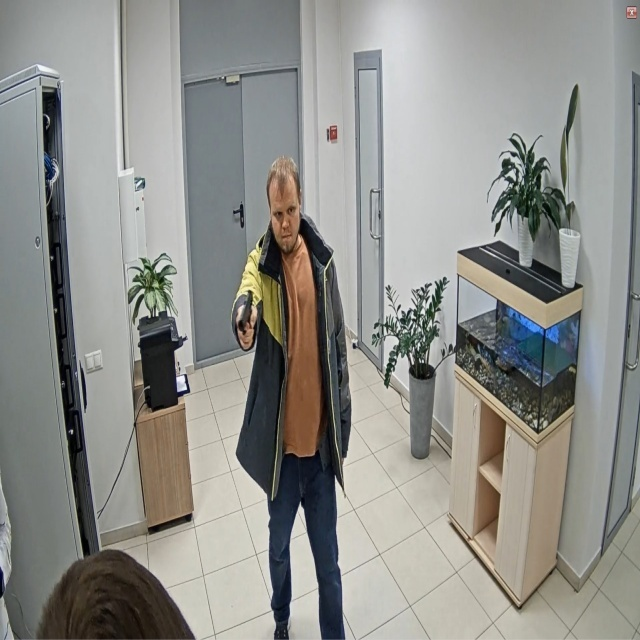

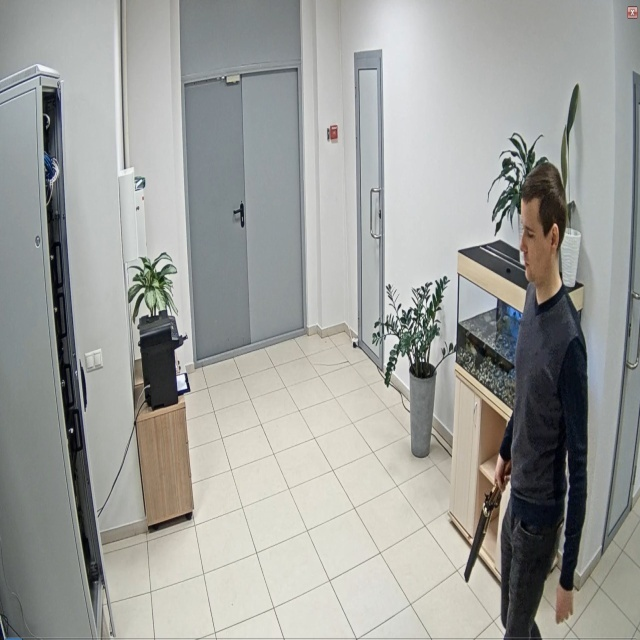

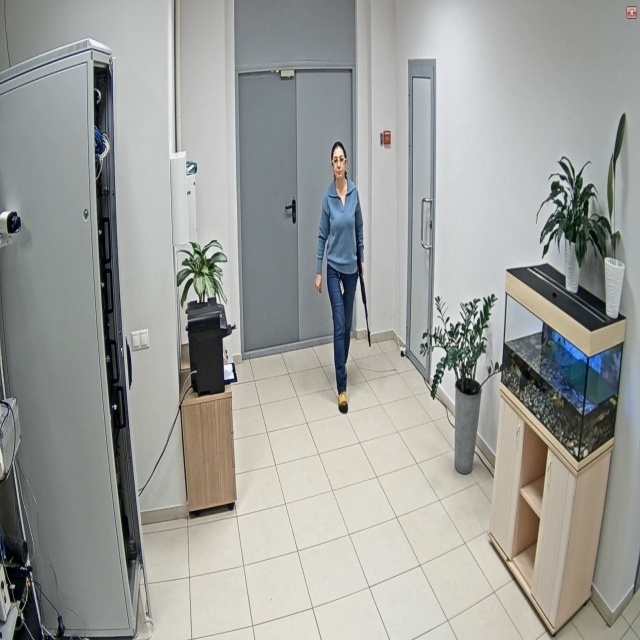

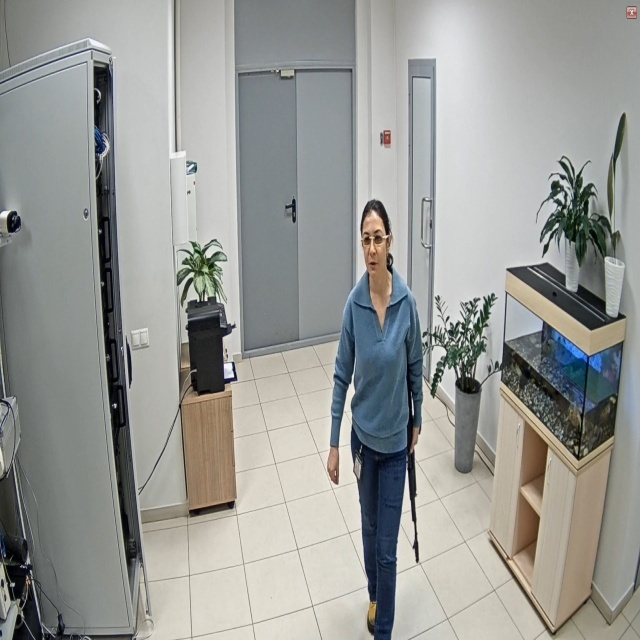

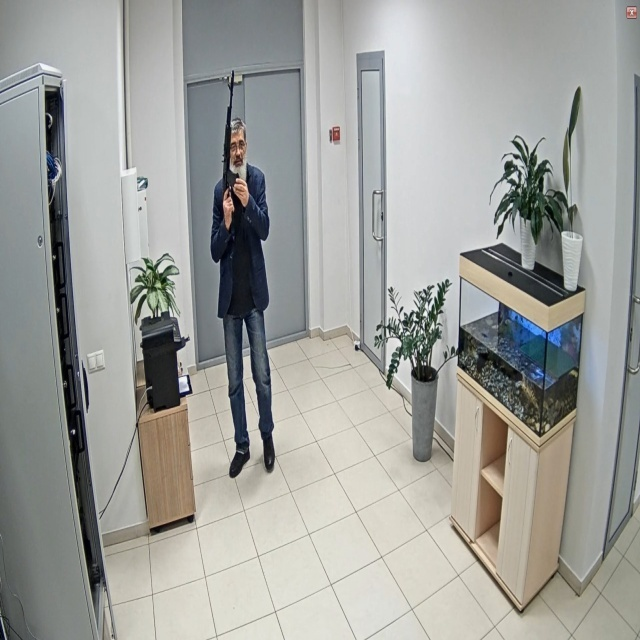

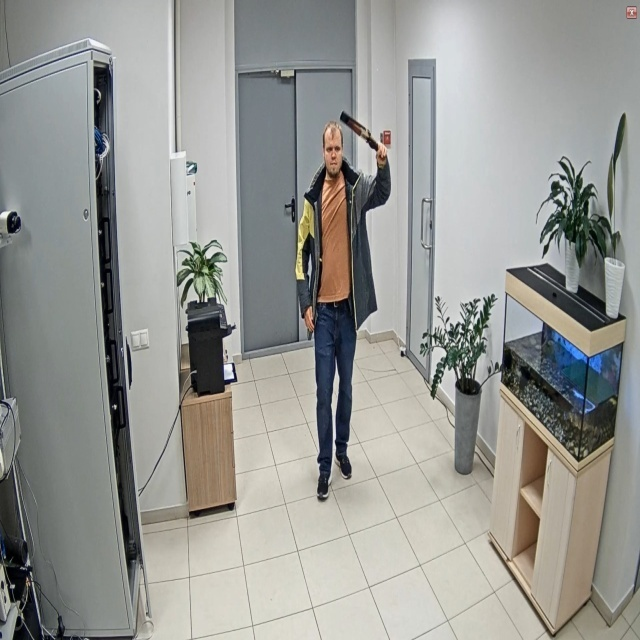

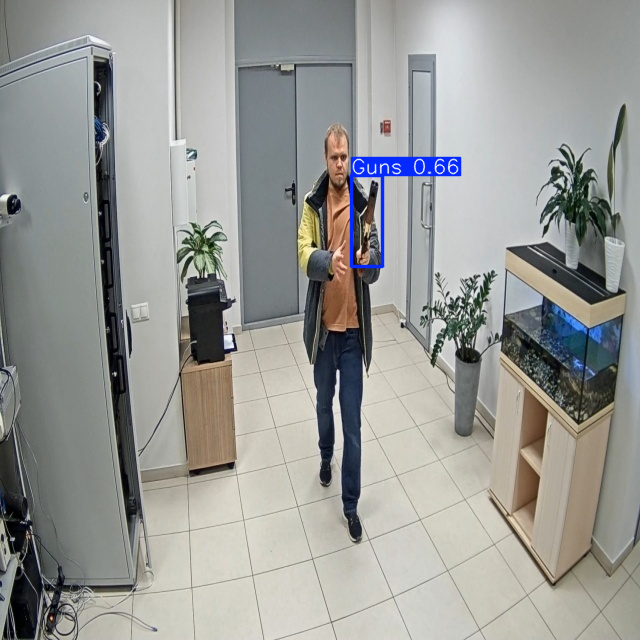

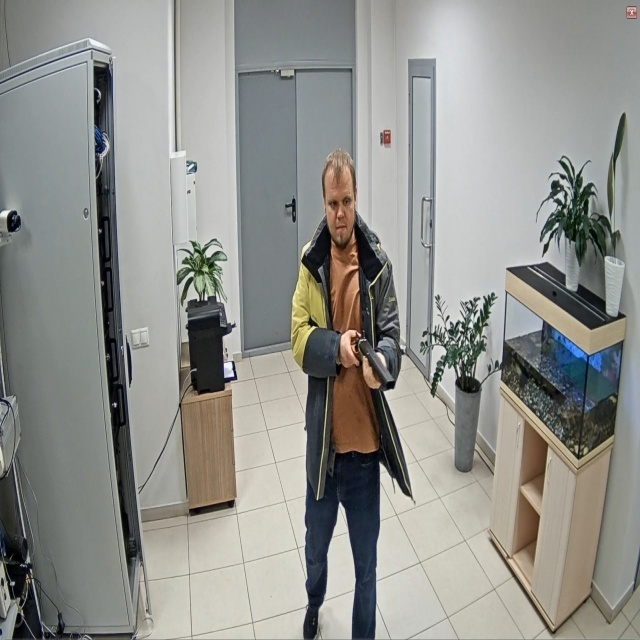

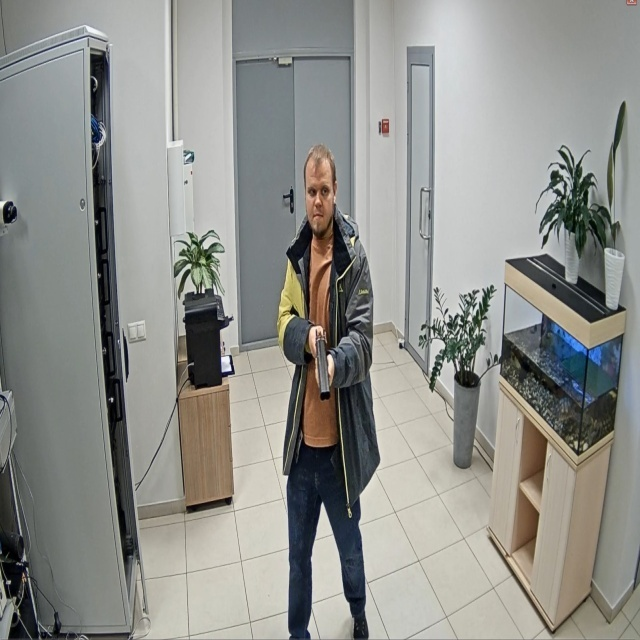

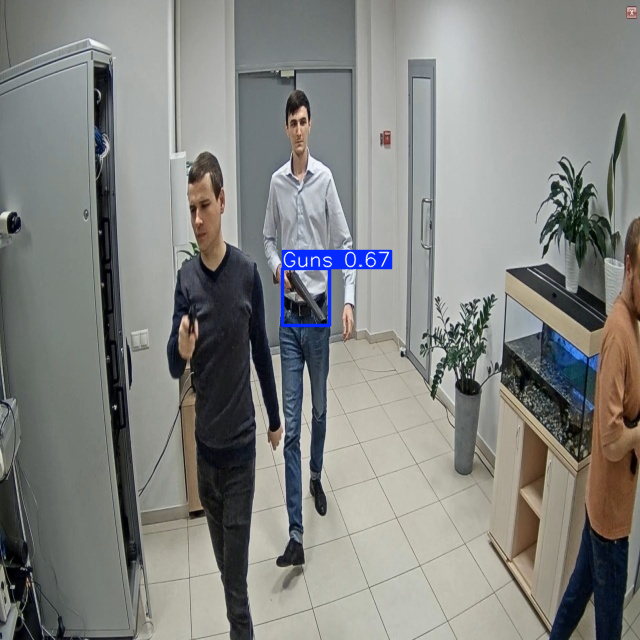

In [11]:
for result in predictions:
    result.show()